In [18]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
np_random, seed = seeding.np_random(42)

In [3]:
a = np.arange(4).reshape((2,2))
print(a)

[[0 1]
 [2 3]]


In [4]:
[0, 1, 2, 3][:1]

[0]

In [5]:
print([row for row in a])

[array([0, 1]), array([2, 3])]


In [6]:
class g2048(gym.Env):
    metadata = {
        'render.modes' : ['human', 'rgb_array'],
        'video.frames_per_second' : 30
    }

    def __init__(self):
        self.board_size = np.array([4, 4])

        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Discrete(np.prod(self.board_size))

        self.seed()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed if seed is not None else np.random.seed())
        return [seed]

    def step(self, move):
        assert int(move) in range(4)
        old_state = self.state.copy()
        old_full = np.sum(old_state == 0)
        
        rotated_state = np.rot90(old_state, move)
        new_rotated_state = []
        for i, row in enumerate(rotated_state):
            zero_counter = 0
            new_row = row.copy()
            for j, value in enumerate(row):
                if value == 0:
                    zero_counter += 1
                else:
                    for k, kvalue in enumerate(new_row[:j]):
                        if kvalue == 0:
                            new_row[k] = value
                            new_row[j] = 0
                            break
                        elif kvalue == value:
                            new_row[k] = new_row[k] + 1
                            new_row[j] = 0
                            break
            new_rotated_state.append(new_row)
        self.state = np.rot90(np.array(new_rotated_state), 4-move)
        
        if (self.state == old_state).all():
            reward = 0
        else:
            reward, _ = self._put_piece()
        
        if np.sum(self.state == 0) == 0:  # No empty positions
            done = True
        else:
            done = False
        
        return self._get_obs(), reward, done, {}
    
    def reset(self):
        self.state = np.zeros(self.board_size, dtype=np.int8)
        self._put_piece()
        self._put_piece()
        return self._get_obs()

    def _get_obs(self):
        return self.state
    
    def _get_pos(self):
        """Select a random position in the state where there is no piece."""
        zero_pos = list(np.array(np.where(self.state == 0)).T)
        return zero_pos[self.np_random.randint(len(zero_pos))]
    
    def _get_piece(self):
        """Select a piece value to be positioned."""
        return 1 if self.np_random.uniform() < 0.9 else 2
    
    def _put_piece(self):
        """Put piece with random value in empty position."""
        position = self._get_pos()
        value = self._get_piece()
        self.state[position[0]][position[1]] = value
        return value, position

    def render(self, mode='human'):

        # TBD
        
        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(500,500)
            self.viewer.set_bounds(-2.2,2.2,-2.2,2.2)
            rod = rendering.make_capsule(1, .2)
            rod.set_color(.8, .3, .3)
            self.pole_transform = rendering.Transform()
            rod.add_attr(self.pole_transform)
            self.viewer.add_geom(rod)
            axle = rendering.make_circle(.05)
            axle.set_color(0,0,0)
            self.viewer.add_geom(axle)
            fname = path.join(path.dirname(__file__), "assets/clockwise.png")
            self.img = rendering.Image(fname, 1., 1.)
            self.imgtrans = rendering.Transform()
            self.img.add_attr(self.imgtrans)

        self.viewer.add_onetime(self.img)
        self.pole_transform.set_rotation(self.state[0] + np.pi/2)
        if self.last_u:
            self.imgtrans.scale = (-self.last_u/2, np.abs(self.last_u)/2)

        return self.viewer.render(return_rgb_array = mode=='rgb_array')

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None


In [16]:
env = PendulumEnv()
rews = []
for tr in range(1000):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        #print(obs)
        action = np.random.choice([0, 1, 2, 3])
        obs, reward, done, _ = env.step(action)
        #clear_output(wait=True)
        total_reward += reward
    rews.append(total_reward)
rews = np.array(rews)
print(rews.mean())

634.763


(array([ 37., 159., 360.,  92., 192., 140.,   2.,   6.,  10.,   2.]),
 array([ 103. ,  265.9,  428.8,  591.7,  754.6,  917.5, 1080.4, 1243.3,
        1406.2, 1569.1, 1732. ]),
 <a list of 10 Patch objects>)

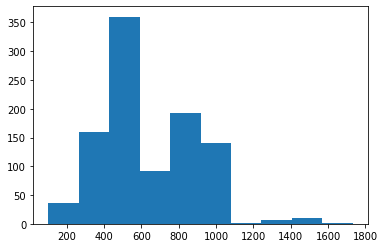

In [19]:
plt.hist(rews)

In [114]:
env.step(0)

[1 3]


(array([[1, 0, 0, 0],
        [0, 0, 0, 1],
        [2, 0, 0, 0],
        [0, 0, 0, 0]], dtype=int8), 1, False, {})

In [115]:
env.step(0)

[2 1]


(array([[1, 0, 0, 0],
        [1, 0, 0, 0],
        [2, 1, 0, 0],
        [0, 0, 0, 0]], dtype=int8), 1, False, {})

In [117]:
env.step(1)

[1 0]


(array([[3, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], dtype=int8), 1, False, {})

In [118]:
env.step(3)

[1 2]


(array([[0, 0, 0, 0],
        [0, 0, 1, 0],
        [3, 0, 0, 0],
        [1, 1, 0, 0]], dtype=int8), 1, False, {})

In [119]:
env.step(0)

[2 2]


(array([[0, 0, 0, 0],
        [1, 0, 0, 0],
        [3, 0, 1, 0],
        [2, 0, 0, 0]], dtype=int8), 1, False, {})